# Many Body Tensor Representation

MBTR is a global descriptor for a molecule/unit cell. It eliminates rotational, translational, and permutation variances by gathering information about different configurations of $K$ atoms into tensors that are stratified by the involved chemical elements. All element combinations have an associated gaussian-smeared exponentially-weighted histogram.

## The Tensor
The tensor comprises of combinations of elements in different numbers. So, K1 is 1 element, K2 is 2 elements, and so on. These K's represent different expression of the molecule/unit-cell.

### K1
K1 represents the gaussian-smeared histogram for **counts** of each element type. So, in essense it is a matrix of size MxN, where M is the number of elements, and N is the number of bins.

![K1](https://github.com/reinimaurer1/ML-CSC-tutorial/blob/master/images/k1.png?raw=1)

### K2
K2 represents the gaussian-smeared exponentially-weighted histogram **inverse distances** of pairs of elements. So, this becomes a tensor of size MxMxN, where M is the number of elements, and N is the number of bins.

![K2](https://github.com/reinimaurer1/ML-CSC-tutorial/blob/master/images/k2.png?raw=1)

### K3
K3 represents the gaussian-smeared exponentially-weighted histogram **angles between triplets** of elements. So, this becomes a tensor of size MxMxMxN, where M is the number of elements, and N is the number of bins.

![K3](https://github.com/reinimaurer1/ML-CSC-tutorial/blob/master/images/k3.png?raw=1)

*Note: the dscribe package has implementation of MBTR up to K3*

### K4 
K4 represents the gaussian-smeared exponantially-weighted histogram **di-hedral angles** between quadruplets of elements. So, this becomes a tensor of size MxMxMxMxN, where M is the number of elements, and N is the number of bins.

![K4](https://github.com/reinimaurer1/ML-CSC-tutorial/blob/master/images/k4.png?raw=1)

## Weighting

All the tensors, but K1, are weighted. This ensures that contributions from nearby atoms is higher, than from farther ones.

For more info about MBTR see:
[Huo, Haoyan, and Matthias Rupp. *arXiv preprint* **arXiv:1704.06439 (2017)**](https://arxiv.org/pdf/1704.06439.pdf)  

For calculating MBTR, we use the [DScribe package](https://singroup.github.io/dscribe) as developed by [Surfaces and Interfaces at the Nanoscale, Aalto](http://physics.aalto.fi/en/groups/sin/)

## Example

We are going to see MBTR in action for a simple NaCl system.

In [2]:
#resolve KRR dependency
import os
!pip install dscribe
# --- INITIAL DEFINITIONS ---
from dscribe.descriptors import MBTR
import numpy as np
from ase.visualize import view
from ase import Atoms
import matplotlib.pyplot as mpl

  Using cached dscribe-1.1.0.tar.gz (143 kB)
  Using cached pybind11-2.7.1-py2.py3-none-any.whl (200 kB)
  Using cached ase-3.22.0-py3-none-any.whl (2.2 MB)
  Using cached sparse-0.12.0-py2.py3-none-any.whl (76 kB)
  Created wheel for dscribe: filename=dscribe-1.1.0-cp37-cp37m-linux_x86_64.whl size=4339900 sha256=c003be1f68a6b409393cc1fe961cd6cca63c503de1cc3f37c36f9b75fca7dbd0
  Stored in directory: /root/.cache/pip/wheels/05/f8/a6/c5328c447d56d1efed920c372cbd0086ac1e01de1b5adaa9db
Successfully built dscribe


### Atom description

We'll make an ase.Atoms class for NaCl

In [3]:
# Define the system under study: NaCl in a conventional cell.
NaCl_conv = Atoms(
    cell=[
        [5.6402, 0.0, 0.0],
        [0.0, 5.6402, 0.0],
        [0.0, 0.0, 5.6402]
    ],
    scaled_positions=[
        [0.0, 0.5, 0.0],
        [0.0, 0.5, 0.5],
        [0.0, 0.0, 0.5],
        [0.0, 0.0, 0.0],
        [0.5, 0.5, 0.5],
        [0.5, 0.5, 0.0],
        [0.5, 0.0, 0.0],
        [0.5, 0.0, 0.5]
    ],
    symbols=["Na", "Cl", "Na", "Cl", "Na", "Cl", "Na", "Cl"],
)
view(NaCl_conv)

### Setting MBTR hyper-parameters

Next we set-up hyper-parameters:
1. species, the chemical elements to include in the MBTR, helps comparing two structures with missing elements
2. k, list/set of K's to be computed
3. grid: dictionary for K1, K2, K3 with
    min, max: are the min and max values for each distribution
    sigma, the exponent coefficient for smearing
    n, number of bins.
4. weights: dictionary of weighting functions to be used.

**Note: The dscribe package has implementation of MBTR up to K3**


In [4]:
# Create the MBTR desciptor for the system
mbtr = MBTR(
    species=['Na', 'Cl'], # Na and Cl
    periodic=True,
    k1={
        "geometry": { "function": "atomic_number" },
        "grid": { "min": 10, "max": 18, "sigma": 0.1, "n": 200 },
    },
    k2={
        "geometry": {"function": "inverse_distance"},
        "grid": { "min": 0, "max": 0.7, "sigma": 0.01, "n": 200 },
        "weighting": {"function": "exp", "scale": 0.75, "cutoff": 1e-3}
    },
    k3={
        "geometry": {"function": "cosine"},
        "grid": { "min": -1.0, "max": 1.0, "sigma": 0.05, "n": 200 },
        "weighting": {"function": "exp", "scale": 0.5, "cutoff": 1e-3}
    },
    
    flatten=False,
    sparse=False)
print("Number of features: {}".format(mbtr.get_number_of_features()))

Number of features: 2200


### Calculate MBTR

We call the create functin of mbtr class over our System(ase.Atoms) object

In [5]:
#Create Descriptor
desc = mbtr.create(NaCl_conv)

### Plotting 

We will now plot all the tensors, in the same plot, for K1, K2, and K3

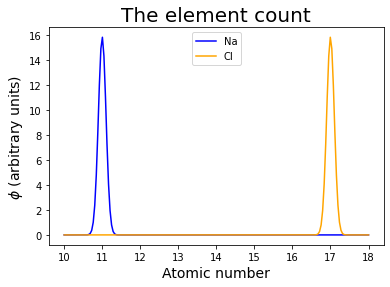

In [6]:
#plot K1
x1 = mbtr.get_k1_axis()
mpl.plot(x1, desc["k1"][0, :], label="Na", color="blue")
mpl.plot(x1, desc["k1"][1, :], label="Cl", color="orange")
mpl.ylabel("$\phi$ (arbitrary units)", size=14)
mpl.xlabel("Atomic number", size=14)
mpl.title("The element count", size=20)
mpl.legend()
mpl.show()

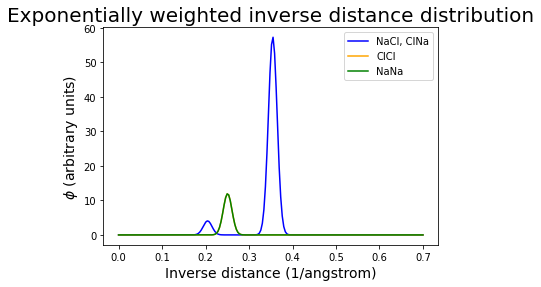

In [7]:
# Plot K2
x2 = mbtr.get_k2_axis()
mpl.plot(x2, desc["k2"][0, 1, :], label="NaCl, ClNa", color="blue")
mpl.plot(x2, desc["k2"][1, 1, :], label="ClCl", color="orange")
mpl.plot(x2, desc["k2"][0, 0, :], label="NaNa", color="green")
mpl.ylabel("$\phi$ (arbitrary units)", size=14)
mpl.xlabel("Inverse distance (1/angstrom)", size=14)
mpl.title("Exponentially weighted inverse distance distribution", size=20)
mpl.legend()
mpl.show()

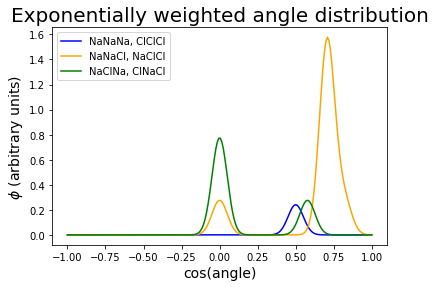

In [8]:
# Plot K3
x3 = mbtr.get_k3_axis()
mpl.plot(x3, desc["k3"][0, 0, 0, :], label="NaNaNa, ClClCl", color="blue")
mpl.plot(x3, desc["k3"][0, 0, 1, :], label="NaNaCl, NaClCl", color="orange")
mpl.plot(x3, desc["k3"][1, 0, 1, :], label="NaClNa, ClNaCl", color="green")
mpl.ylabel("$\phi$ (arbitrary units)", size=14)
mpl.xlabel("cos(angle)", size=14)
mpl.title("Exponentially weighted angle distribution", size=20)
mpl.legend()
mpl.show()

## Remark

The MBTR is a fingerprint of the entire system. Thus, it can be used to:
1. Compare the similarity of two chemical system by taking comparing the MBTR values.
2. Machine learn total properties, like energies, dipole moment, etc.

## Exercise

Verify that the MBTR is translationally and rotationally invariant.